Выполнила: Борисова Мария

# <center> Анализ зависимости параметров подсчета запасов </center>

При подсчете запасов объемным методом используют формулу:<br>

<center>$Q_н=S*h_н*K_п*K_н*\theta*\rho*КИН$,</center>

<blockquote>где $Q_н$ – геологические запасы нефти, тыс. т,<br>
$S$ – площадь залежи или части залежи, тыс. $м^2$,<br>
$h_н$ – нефтенасыщенная толщина, м,<br>
$К_п$ – коэффициент пористости (пустотности), д.ед..<br>
$К_н$ – коэффициент нефтенасыщенности, д.ед.,<br>
$\theta$ – пересчетный коэффициент, д.ед.,<br>
$\rho$ – плотность нефти, $т/м^3$,<br>
$КИН$ – коэффициент извлечения нефти, д.ед.<br>
</blockquote>

В некоторых случаях затруднительно получение тех или иных составляющих приведенной формулы, поэтому возможно зависимость параметров между собой или с дополнительными измерениями позволит заполнить пропуски в данных.

In [1]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pylab
import math
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [3]:
df = pd.read_csv('kval_data.csv',sep=",",index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 1 to 150
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Месторождение                      145 non-null    object
 1   Тип                                145 non-null    object
 2   Продуктивный горизонт              145 non-null    object
 3   Коэфф. Извлечения                  145 non-null    object
 4   площадь нефтеносности, тыс.м2      145 non-null    int64 
 5   Нефтенасыщенная толщина,эффект. м  145 non-null    object
 6   Открытая пористость                145 non-null    object
 7   Нефтенасыщенность                  145 non-null    object
 8   Пересчетный коэф-т                 145 non-null    object
 9   Плотность г/см3                    145 non-null    object
 10  Проницаемость, мкм2                145 non-null    object
 11  Вязкость в пласт.условиях,мПа.с    145 non-null    object
 12  Содержан

В таблице параметры можно разделить на три части - информация о данных (месторождение, тип, прод. горизонт, глубина залегания), параметры для подсчета запасов (коэф-т извлечения, площадь, нефтенасыщ. толщина, пористость, нефтенасыщенность, пересчетный коэф-т, плотность), дополнительные параметры (проницаемость, вязкость, содержание серы, парафина, смол и асфальтенов, пластовая температура). </br>
Далее работа будет разбита на три части:
<ul>
    1. Поиск зависимостей между параметрами подсчета запасов. <br>
    2. Поиск зависимостей между дополнительными параметрами. <br>
    3. Поиск зависимостей между парметрами подсчета запасов и дополнительными параметрами.<br>
</ul>   
Но первым делом данные требуется подготовить к анализу.

<div class="alert alert-block alert-info">
<b>Предобработка данных </b>
</div>

- Для корректной работы с параметрами следует заметить запятые на точки и изменить тип данных str -> float

In [4]:
сolumns = df.columns
for i in сolumns:
    try:
        df[i] = df[i].str.replace(",", ".").astype(float)
    except:
        pass

- Импутация нулевых значений. Следует удалить или заменить нулевые / отсутствующие значения.

In [5]:
#на данном этапе отсекаются данные о месторождениях и нули превращаются в None
df_without_0 = df[сolumns[3:-2]][df[сolumns[3:-2]] >0]
columns_parametr = df_without_0.columns
df_without_0

,Коэфф. Извлечения,"площадь нефтеносности, тыс.м2","Нефтенасыщенная толщина,эффект. м",Открытая пористость,Нефтенасыщенность,Пересчетный коэф-т,Плотность г/см3,"Проницаемость, мкм2","Вязкость в пласт.условиях,мПа.с","Содержание серы, %","Содержание парафина, %",Содерж. Смол и асфальтенов,"Пластовая Т, град."
1,0.326,11550,115.5,0.0025,0.900,0.732,0.872,0.016,0.753,1.10,6.29,17.06,32.0
2,0.270,18334,88.7,0.0200,0.820,0.936,0.909,0.012,11.000,2.60,3.20,29.70,32.0
3,0.250,2508,4.1,0.0800,0.780,0.911,0.884,0.039,7.750,2.52,2.73,15.00,51.0
4,0.336,681,2.8,0.0880,0.758,0.944,0.903,0.109,17.000,3.08,3.66,22.47,30.0
5,0.292,3581,3.7,0.0700,0.703,0.944,0.903,0.109,17.000,3.08,3.66,22.47,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.204,8600,2.5,0.1100,0.770,0.970,0.873,0.009,6.460,3.00,3.60,19.50,23.0
146,0.249,1605,2.5,0.0900,0.750,0.900,0.894,0.008,5.170,2.60,5.40,14.90,35.0
147,0.249,33,1.8,0.0900,0.750,0.900,0.894,0.008,5.170,2.79,2.79,NaN,35.0
149,0.345,83,1.8,0.0800,0.683,0.917,0.878,0.015,6.500,2.62,3.00,15.20,30.0


In [6]:
#использую медианное значение
for i in df_without_0[columns_parametr]:
    median=np.median(df[i].values)
    df_without_0[i]=df_without_0[i].fillna(median)
df_without_0

,Коэфф. Извлечения,"площадь нефтеносности, тыс.м2","Нефтенасыщенная толщина,эффект. м",Открытая пористость,Нефтенасыщенность,Пересчетный коэф-т,Плотность г/см3,"Проницаемость, мкм2","Вязкость в пласт.условиях,мПа.с","Содержание серы, %","Содержание парафина, %",Содерж. Смол и асфальтенов,"Пластовая Т, град."
1,0.326,11550,115.5,0.0025,0.900,0.732,0.872,0.016,0.753,1.10,6.29,17.06,32.0
2,0.270,18334,88.7,0.0200,0.820,0.936,0.909,0.012,11.000,2.60,3.20,29.70,32.0
3,0.250,2508,4.1,0.0800,0.780,0.911,0.884,0.039,7.750,2.52,2.73,15.00,51.0
4,0.336,681,2.8,0.0880,0.758,0.944,0.903,0.109,17.000,3.08,3.66,22.47,30.0
5,0.292,3581,3.7,0.0700,0.703,0.944,0.903,0.109,17.000,3.08,3.66,22.47,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.204,8600,2.5,0.1100,0.770,0.970,0.873,0.009,6.460,3.00,3.60,19.50,23.0
146,0.249,1605,2.5,0.0900,0.750,0.900,0.894,0.008,5.170,2.60,5.40,14.90,35.0
147,0.249,33,1.8,0.0900,0.750,0.900,0.894,0.008,5.170,2.79,2.79,18.04,35.0
149,0.345,83,1.8,0.0800,0.683,0.917,0.878,0.015,6.500,2.62,3.00,15.20,30.0


- В целях оптимального качества работы требуется, чтобы параметры находились в одной и той же шкале, поэтому масштабирую все данные к шкале [0,1].

In [7]:
l=[]
L=[]

df_normaliz=df_without_0.copy()

for i in columns_parametr:
    l+=[min(df_normaliz[i].values)]
    L+=[max(df_normaliz[i].values)]
print(l,len(l))
print(L,len(L))

[0.096, 29, 0.5, 0.0025, 0.683, 0.696, 0.836, 0.001, 0.753, 1.03, 0.539, 4.0, 23.0] 13
[0.569, 32356, 115.5, 11.0, 0.941, 0.993, 0.945, 0.482, 105.9, 6.8, 25.0, 302.14, 51.0] 13


In [8]:
#использую нормализацию
for i in columns_parametr:
    df_normaliz[i]=(df_normaliz[i]-min(df_normaliz[i].values))/(max(df_normaliz[i].values)-min(df_normaliz[i].values))
df_normaliz   

,Коэфф. Извлечения,"площадь нефтеносности, тыс.м2","Нефтенасыщенная толщина,эффект. м",Открытая пористость,Нефтенасыщенность,Пересчетный коэф-т,Плотность г/см3,"Проницаемость, мкм2","Вязкость в пласт.условиях,мПа.с","Содержание серы, %","Содержание парафина, %",Содерж. Смол и асфальтенов,"Пластовая Т, град."
1,0.486258,0.356389,1.000000,0.000000,0.841085,0.121212,0.330275,0.031185,0.000000,0.012132,0.235109,0.043805,0.321429
2,0.367865,0.566245,0.766957,0.001591,0.531008,0.808081,0.669725,0.022869,0.097454,0.272097,0.108785,0.086201,0.321429
3,0.325581,0.076685,0.031304,0.007047,0.375969,0.723906,0.440367,0.079002,0.066545,0.258232,0.089571,0.036895,1.000000
4,0.507400,0.020169,0.020000,0.007774,0.290698,0.835017,0.614679,0.224532,0.154517,0.355286,0.127591,0.061951,0.250000
5,0.414376,0.109877,0.027826,0.006138,0.077519,0.835017,0.614679,0.224532,0.154517,0.355286,0.127591,0.061951,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.228330,0.265134,0.017391,0.009775,0.337209,0.922559,0.339450,0.016632,0.054276,0.341421,0.125138,0.051989,0.000000
146,0.323467,0.048752,0.017391,0.007956,0.259690,0.686869,0.532110,0.014553,0.042008,0.272097,0.198725,0.036560,0.428571
147,0.323467,0.000124,0.011304,0.007956,0.259690,0.686869,0.532110,0.014553,0.042008,0.305026,0.092024,0.047092,0.428571
149,0.526427,0.001670,0.011304,0.007047,0.000000,0.744108,0.385321,0.029106,0.054657,0.275563,0.100609,0.037566,0.250000


In [9]:
l=[]
L=[]
for i in columns_parametr:
    l+=[min(df_normaliz[i].values)]
    L+=[max(df_normaliz[i].values)]
print(l,len(l))
print(L,len(L))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 13
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 13


<div class="alert alert-block alert-info">
<b>Поиск зависимостей между параметрами подсчета запасов </b>
</div>

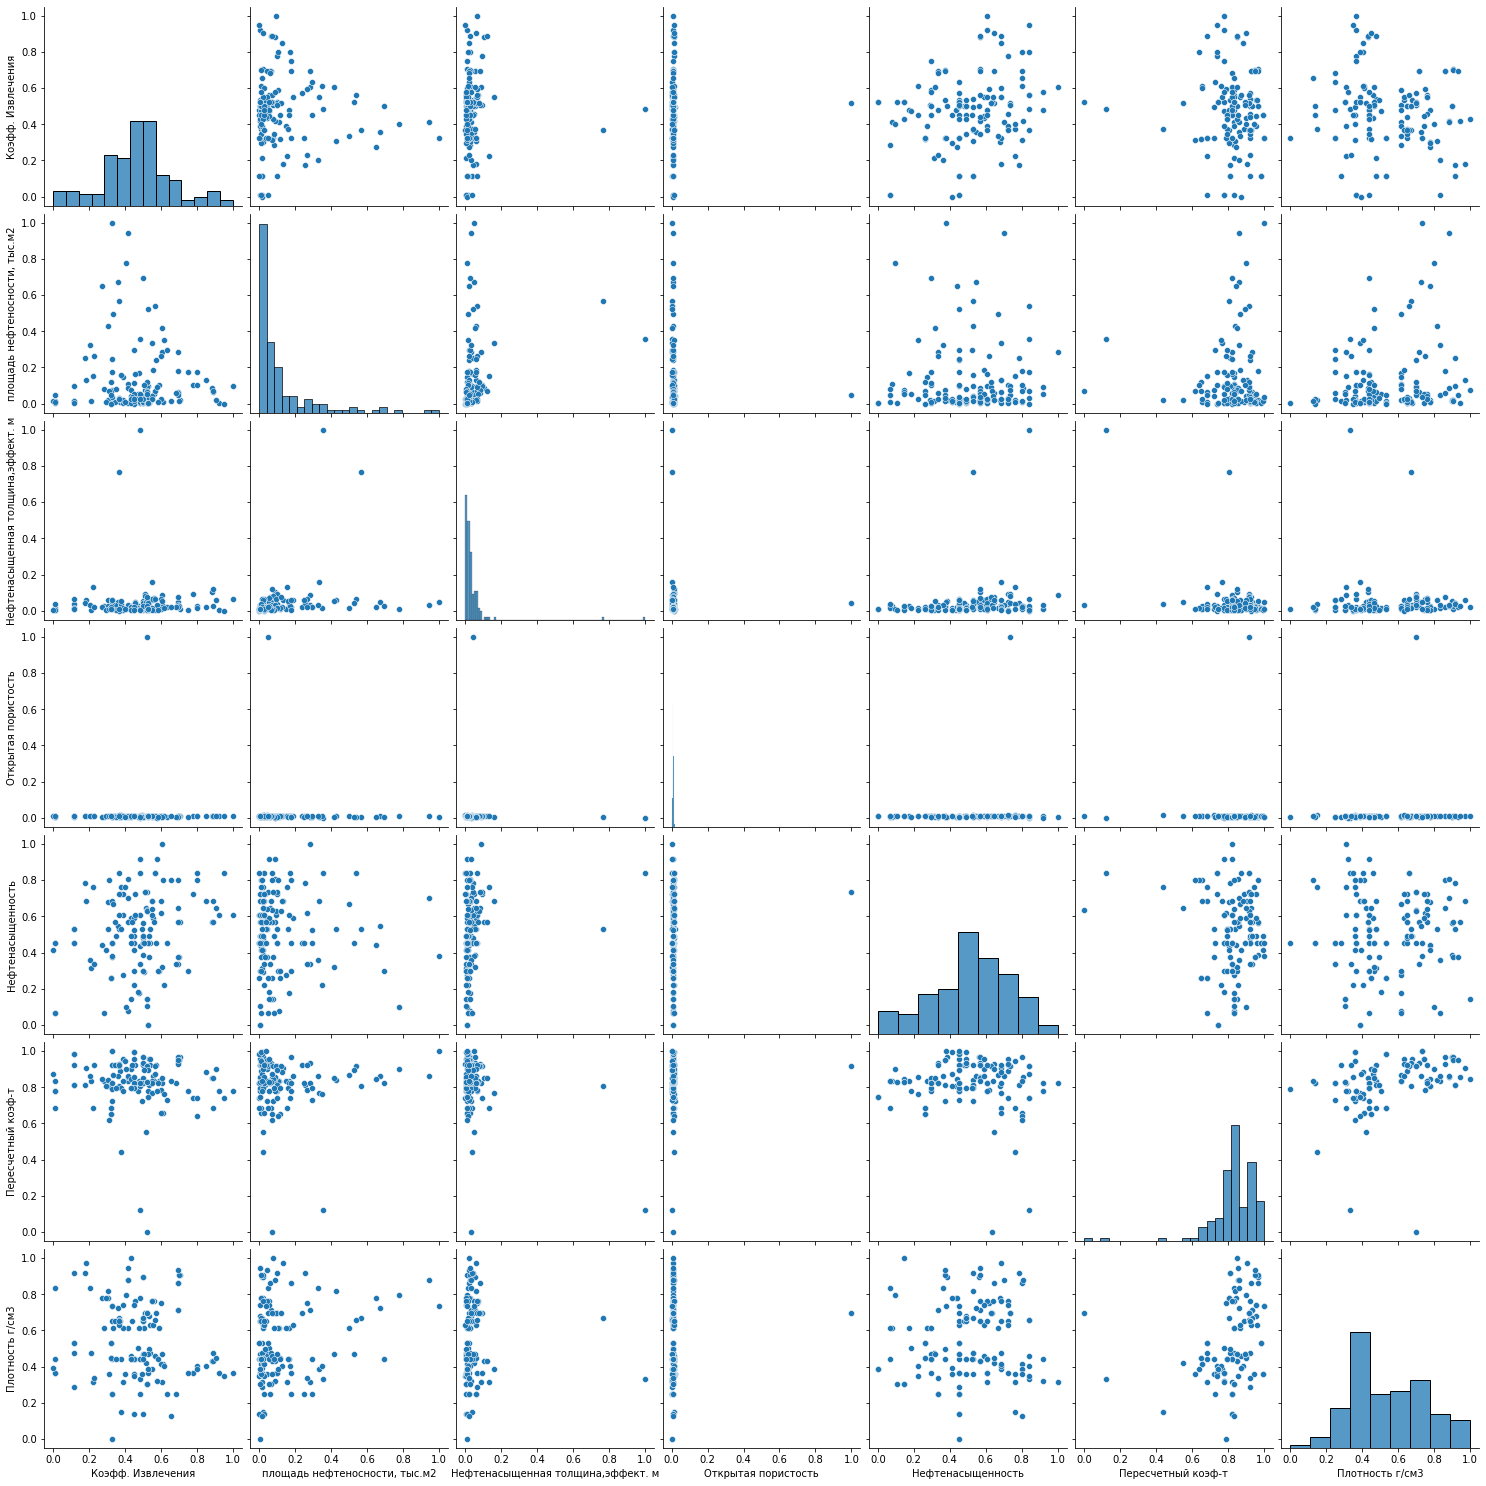

In [10]:
sns.pairplot(df_normaliz[columns_parametr[:7]], height=3)

Видны выбросы некоторых параметров.

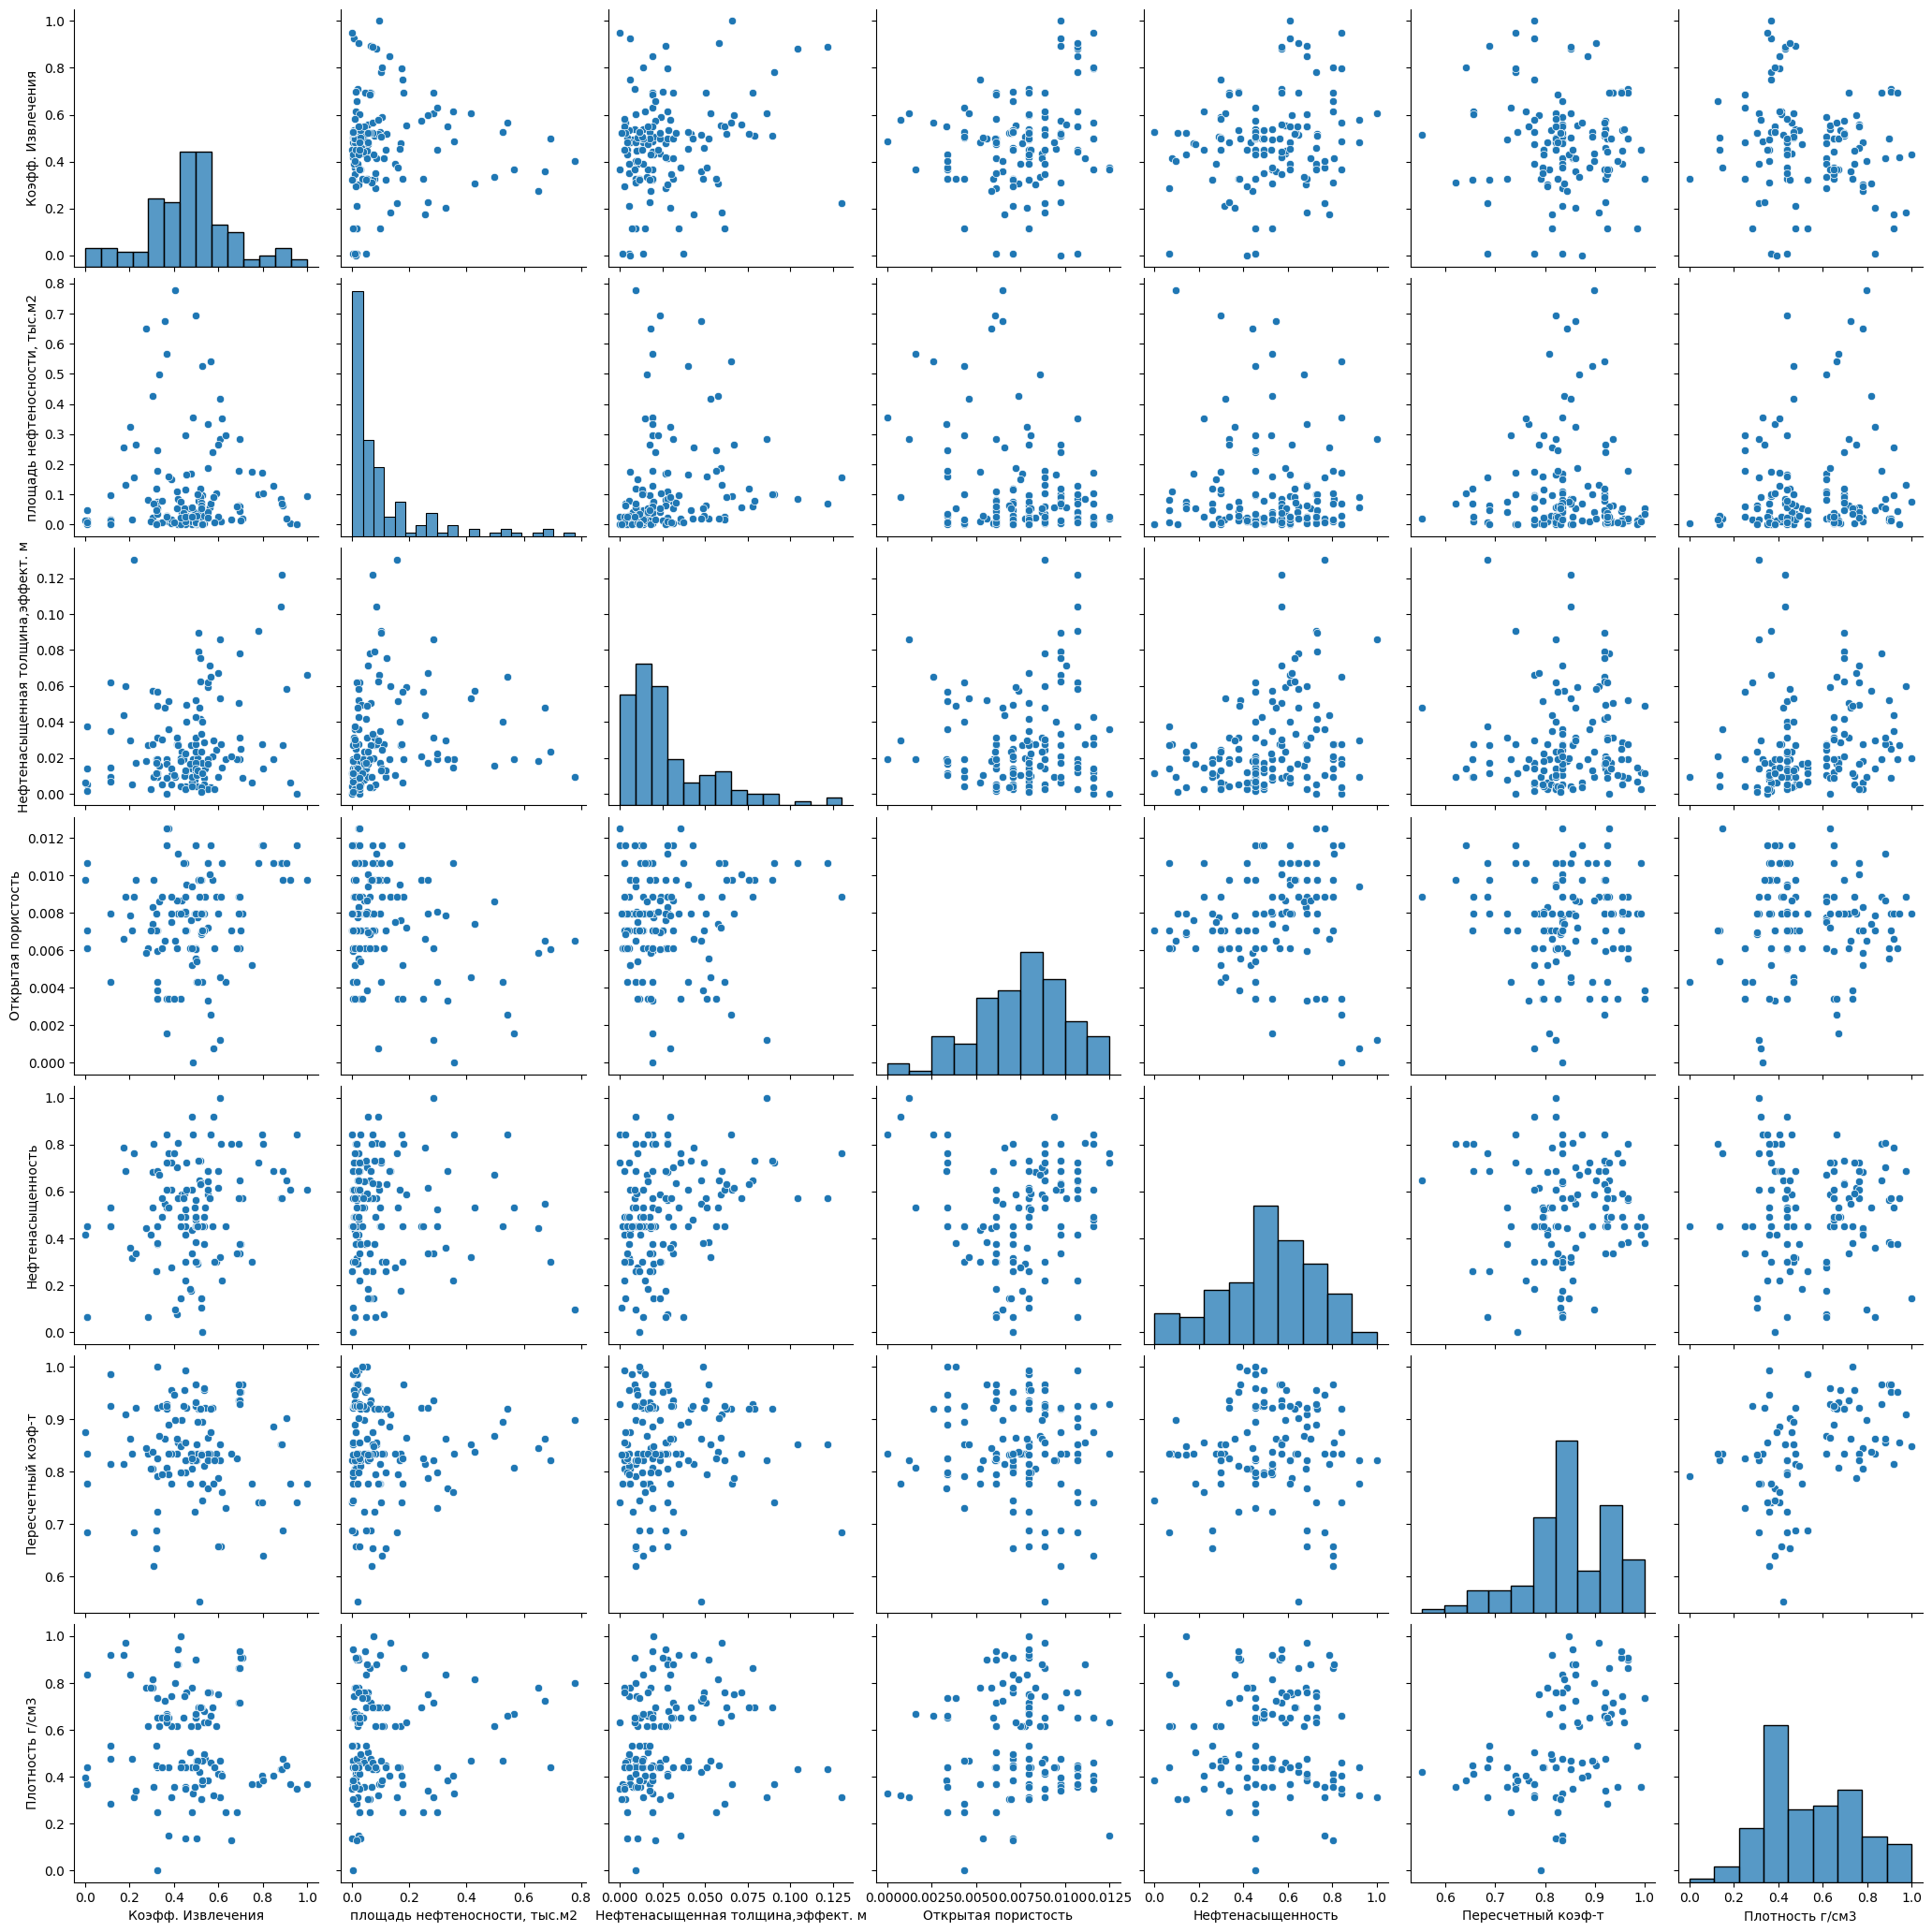

In [11]:
a=lambda x: x<0.81 #для площади
b=lambda x: x<0.15 #для толщины
c=lambda x: x>0.5 #для пересчетного коэф-та
d=lambda x: x<0.014 #для пористости

df_part1_clear= df_normaliz[columns_parametr[:7]].copy()
df_part1_clear['Коэфф. Извлечения']= df_normaliz['Коэфф. Извлечения'].copy()
df_part1_clear['площадь нефтеносности, тыс.м2']= df_normaliz['площадь нефтеносности, тыс.м2'][a]
df_part1_clear['Нефтенасыщенная толщина,эффект. м']= df_normaliz['Нефтенасыщенная толщина,эффект. м'][b]
df_part1_clear['Открытая пористость']= df_normaliz['Открытая пористость'][d]
df_part1_clear['Нефтенасыщенность']= df_normaliz['Нефтенасыщенность'].copy()
df_part1_clear['Пересчетный коэф-т']= df_normaliz['Пересчетный коэф-т'][c]
df_part1_clear['Плотность г/см3']= df_normaliz['Плотность г/см3'].copy()

for i in df_without_0[columns_parametr[:7]]:
    median=np.median(df_normaliz[i].values)
    df_part1_clear[i]=df_part1_clear[i].fillna(median)
df_part1_clear

sns.pairplot(df_part1_clear, height=3)

- Для определения количества линейной связи между признаками теперь создам корреляционную матрицу с линейными коэффициентами корреляции Пирсона

<AxesSubplot:>

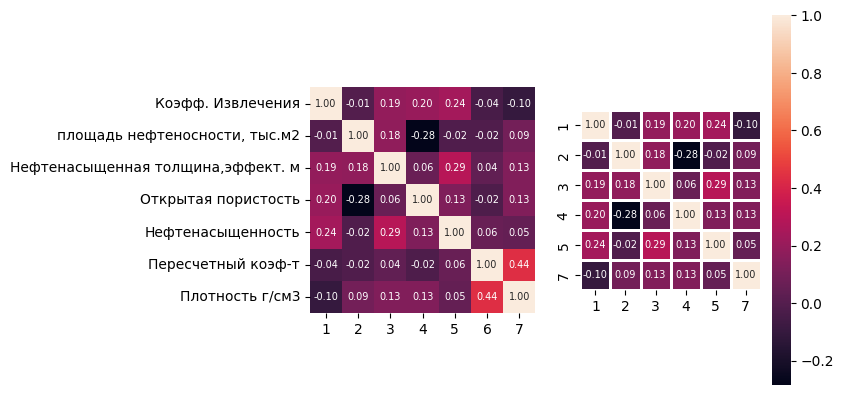

In [12]:
pylab.subplot (1, 2, 1)
sns.heatmap(df_part1_clear.corr(),cbar=False , annot=True , annot_kws={ 'size': 7},fmt='.2f', square=True, xticklabels=[1,2,3,4,5,6,7] )

df_part1_without_coef=df_part1_clear.copy()
df_part1_without_coef.pop('Пересчетный коэф-т')

pylab.subplot (1, 2, 2)
sns.heatmap(df_part1_without_coef.corr(),cbar=True , annot=True , annot_kws={ 'size': 7},fmt='.2f',square=True,xticklabels=[1,2,3,4,5,7], yticklabels=[1,2,3,4,5,7],linewidths=2)

Пересчетный коэф-т учитывает различия плотности нефти в пластовых и стандартных условиях, вероятно это и обуславливает высокую корреляцию.

<strong>Линейная регрессионная модель</strong>

- Линейная регрессия для коэф-та извлечения и открытой пористости

In [13]:
x_0=df_part1_clear['Коэфф. Извлечения'].values
y_0=df_part1_clear['Открытая пористость'].values

x=np.array(x_0).reshape((-1, 1))
y=np.array(y_0)

In [14]:
def line_reg(x,y):
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    b_0 = model.intercept_
    b_1 = model.coef_
    return r_sq, model.intercept_, model.coef_, model

In [15]:
t=line_reg(x,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],*t[2]))

coefficient of determination(R^2):0.041865712023567925
intercept(b_0):0.0063567704392874505
slope(b_1):0.002649029394314187


Text(0, 0.5, 'Открытая пористость')

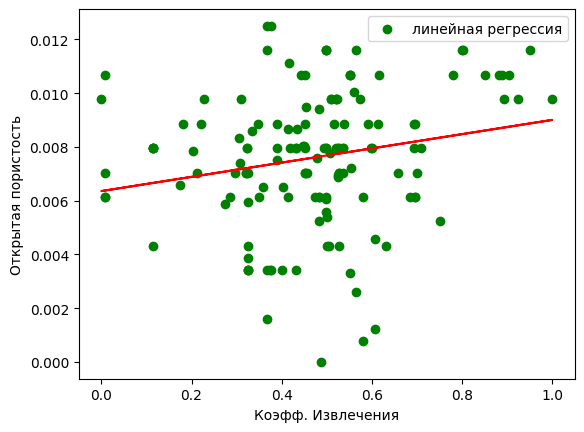

In [16]:
y_pred = t[-1].predict(x)
plt.scatter(x_0, y_0, color='green')
plt.plot( x, y_pred,'r-')
plt.legend(['линейная регрессия'])
plt.xlabel('Коэфф. Извлечения')
plt.ylabel('Открытая пористость')

Некоторые значения коэф-та извечения в интевале [0.3,0.7] очень далеко находятся от прямой регресси (имеют остатки/ошибки модели). Плохое соответствие модели данным также отражается небольшом значении коэффициента детерминации (менее 0.5).

In [17]:
x=np.array(y_0).reshape((-1, 1))
y=np.array(x_0)

In [18]:
t=line_reg(x,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],*t[2]))

coefficient of determination(R^2):0.041865712023568036
intercept(b_0):0.3491478590724618
slope(b_1):15.804170430659441


При смене данных по x и y $R^2$ не изменяется.

- Аналогичное выполню со всеми параметрами подсчета

In [19]:
line_reg_res=[]
for i in df_part1_clear[columns_parametr[:7]]:
    x=np.array(df_part1_clear[i].values).reshape((-1, 1))
    for k in df_part1_clear[columns_parametr[1:6]]:
        y=np.array(df_part1_clear[k].values)
        t=line_reg(x,y)
        if t[0]==1:
            continue
        line_reg_res+=[i+' | '+ k + ': ' + str(round(t[0],4))]
line_reg_res

['Коэфф. Извлечения | площадь нефтеносности, тыс.м2: 0.0',
 'Коэфф. Извлечения | Нефтенасыщенная толщина,эффект. м: 0.0361',
 'Коэфф. Извлечения | Открытая пористость: 0.0419',
 'Коэфф. Извлечения | Нефтенасыщенность: 0.0573',
 'Коэфф. Извлечения | Пересчетный коэф-т: 0.0016',
 'площадь нефтеносности, тыс.м2 | Нефтенасыщенная толщина,эффект. м: 0.033',
 'площадь нефтеносности, тыс.м2 | Открытая пористость: 0.0809',
 'площадь нефтеносности, тыс.м2 | Нефтенасыщенность: 0.0003',
 'площадь нефтеносности, тыс.м2 | Пересчетный коэф-т: 0.0003',
 'Нефтенасыщенная толщина,эффект. м | площадь нефтеносности, тыс.м2: 0.033',
 'Нефтенасыщенная толщина,эффект. м | Открытая пористость: 0.004',
 'Нефтенасыщенная толщина,эффект. м | Нефтенасыщенность: 0.0856',
 'Нефтенасыщенная толщина,эффект. м | Пересчетный коэф-т: 0.0017',
 'Открытая пористость | площадь нефтеносности, тыс.м2: 0.0809',
 'Открытая пористость | Нефтенасыщенная толщина,эффект. м: 0.004',
 'Открытая пористость | Нефтенасыщенность: 0.017

$R^2$ во всех случаях меньше 0,5, следовательно линейных зависимостей между параметрами нет.

<strong>Полиномиальная регрессионная модель</strong>

- Полиноминальная линейная регрессия для коэф-та извлечения и открытой пористости

In [20]:
x_0=df_part1_clear['Коэфф. Извлечения'].values
y_0=df_part1_clear['Открытая пористость'].values

x=np.array(x_0).reshape((-1, 1))
y=np.array(y_0)

In [21]:
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(x)

t_2=line_reg(X_poly,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],*t[2]))

coefficient of determination(R^2):0.19062557967364258
intercept(b_0):0.7428427932782776
slope(b_1):0.18267251186334363


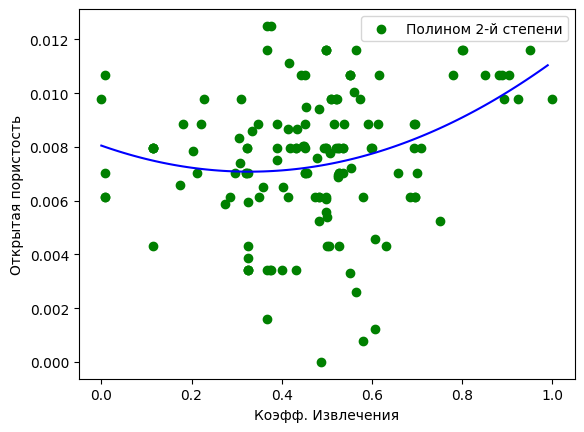

In [22]:
X_grid = np.arange(min(x),max(x),0.01)
X_grid = X_grid.reshape(len(X_grid),1) 
plt.scatter(x,y, color='green') 

plt.plot(X_grid, t_2[-1].predict(poly_reg.fit_transform(X_grid)),color='blue') 

plt.legend(['Полином 2-й степени'])
plt.xlabel('Коэфф. Извлечения')
plt.ylabel('Открытая пористость')
plt.show()

In [23]:
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(x)

t_3=line_reg(X_poly,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],*t[2]))

coefficient of determination(R^2):0.19062557967364258
intercept(b_0):0.7428427932782776
slope(b_1):0.18267251186334363


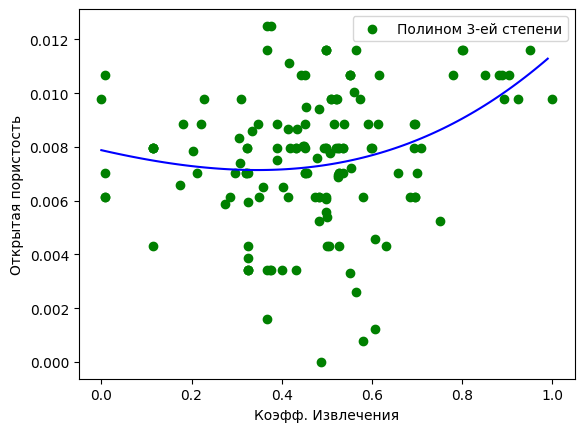

In [24]:
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y)

X_grid = np.arange(min(x),max(x),0.01)
X_grid = X_grid.reshape(len(X_grid),1) 
plt.scatter(x,y, color='green') 

plt.plot(X_grid, lin_reg2.predict(poly_reg.fit_transform(X_grid)),color='blue') 

plt.legend(['Полином 3-ей степени'])
plt.xlabel('Коэфф. Извлечения')
plt.ylabel('Открытая пористость')
plt.show()

In [25]:
poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(x)

t=line_reg(X_poly,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],*t[2]))

coefficient of determination(R^2):0.09060376076845389
intercept(b_0):0.007983938167185617
slope(b_1):0.0


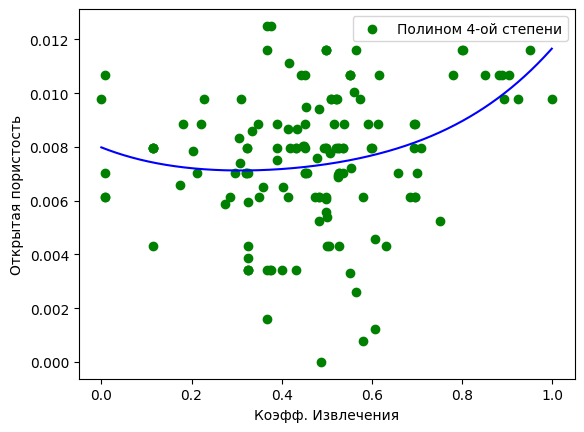

In [26]:
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y)

X_grid = np.arange(min(x),max(x),0.001)
X_grid = X_grid.reshape(len(X_grid),1) 
plt.scatter(x,y, color='green') 

plt.plot(X_grid, lin_reg2.predict(poly_reg.fit_transform(X_grid)),color='blue') 

plt.legend(['Полином 4-ой степени'])
plt.xlabel('Коэфф. Извлечения')
plt.ylabel('Открытая пористость')
plt.show()

С увеличением степени модель улучшается, но этого все равно недостаточно.

- Аналогичные вычисления выполню со всеми параметрами подсчета.

In [27]:
poly_reg_res=[]
for i in df_part1_clear[columns_parametr[:7]]:
    x=np.array(df_part1_clear[i].values).reshape((-1, 1))
    for k in df_part1_clear[columns_parametr[1:6]]:
        y=np.array(df_part1_clear[k].values)
        pak=[]
        for n in range(2,6):
            poly_reg = PolynomialFeatures(degree=n)
            X_poly = poly_reg.fit_transform(x)
            t=line_reg(X_poly,y)
            if t[0]==1:
                continue
            pak+=[round(t[0],4)]
        if len(pak)!=0:
            poly_reg_res+=[i+' | '+ k + ': ' + str(pak)]
poly_reg_res

['Коэфф. Извлечения | площадь нефтеносности, тыс.м2: [0.0123, 0.0163, 0.0319, 0.0328]',
 'Коэфф. Извлечения | Нефтенасыщенная толщина,эффект. м: [0.051, 0.0547, 0.078, 0.0857]',
 'Коэфф. Извлечения | Открытая пористость: [0.0897, 0.0903, 0.0906, 0.0954]',
 'Коэфф. Извлечения | Нефтенасыщенность: [0.0583, 0.0686, 0.0813, 0.0818]',
 'Коэфф. Извлечения | Пересчетный коэф-т: [0.0244, 0.0265, 0.0271, 0.0362]',
 'площадь нефтеносности, тыс.м2 | Нефтенасыщенная толщина,эффект. м: [0.1243, 0.1507, 0.1786, 0.1791]',
 'площадь нефтеносности, тыс.м2 | Открытая пористость: [0.0812, 0.1193, 0.1261, 0.1272]',
 'площадь нефтеносности, тыс.м2 | Нефтенасыщенность: [0.0279, 0.0325, 0.0457, 0.0459]',
 'площадь нефтеносности, тыс.м2 | Пересчетный коэф-т: [0.0166, 0.0211, 0.0216, 0.0255]',
 'Нефтенасыщенная толщина,эффект. м | площадь нефтеносности, тыс.м2: [0.0665, 0.0765, 0.077, 0.0843]',
 'Нефтенасыщенная толщина,эффект. м | Открытая пористость: [0.0248, 0.0263, 0.0267, 0.0455]',
 'Нефтенасыщенная толщи

Лучше всего результат Открытая пористость - Нефтенасыщенность. Попробую увеличить степень полинома.

In [28]:
x_0=df_part1_clear['Открытая пористость'].values
y_0=df_part1_clear['Нефтенасыщенность'].values

x=np.array(x_0).reshape((-1, 1))
y=np.array(y_0)

In [29]:
poly_reg = PolynomialFeatures(degree=6)
X_poly = poly_reg.fit_transform(x)

t=line_reg(X_poly,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],t[2]))

coefficient of determination(R^2):0.3269360533380633
intercept(b_0):0.8675605390253084
slope(b_1):[ 0.00000000e+00 -2.49621880e+01  3.91195002e+04 -3.82348489e+07
  8.66589795e+09 -7.45538874e+11  2.22184958e+13]


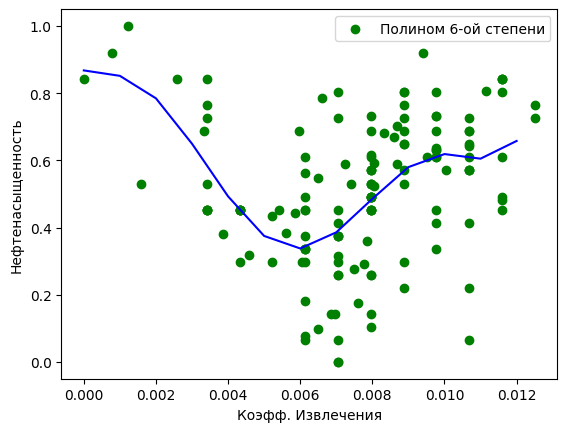

In [30]:
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y)

X_grid = np.arange(min(x),max(x),0.001)
X_grid = X_grid.reshape(len(X_grid),1) 
plt.scatter(x,y, color='green') 

plt.plot(X_grid, lin_reg2.predict(poly_reg.fit_transform(X_grid)),color='blue') 

plt.legend(['Полином 6-ой степени'])
plt.xlabel('Коэфф. Извлечения')
plt.ylabel('Нефтенасыщенность')
plt.show()

При дальнейшем увеличении степени полинома результат не улучшается.

<div class="alert alert-block alert-info">
<b>Поиск зависимостей между дополнительными параметрами </b>
</div>

Для дополнительных параметров аналогично основным также сделаю отчистку от выбросов, расчитаю линейные и полимиальные модели.

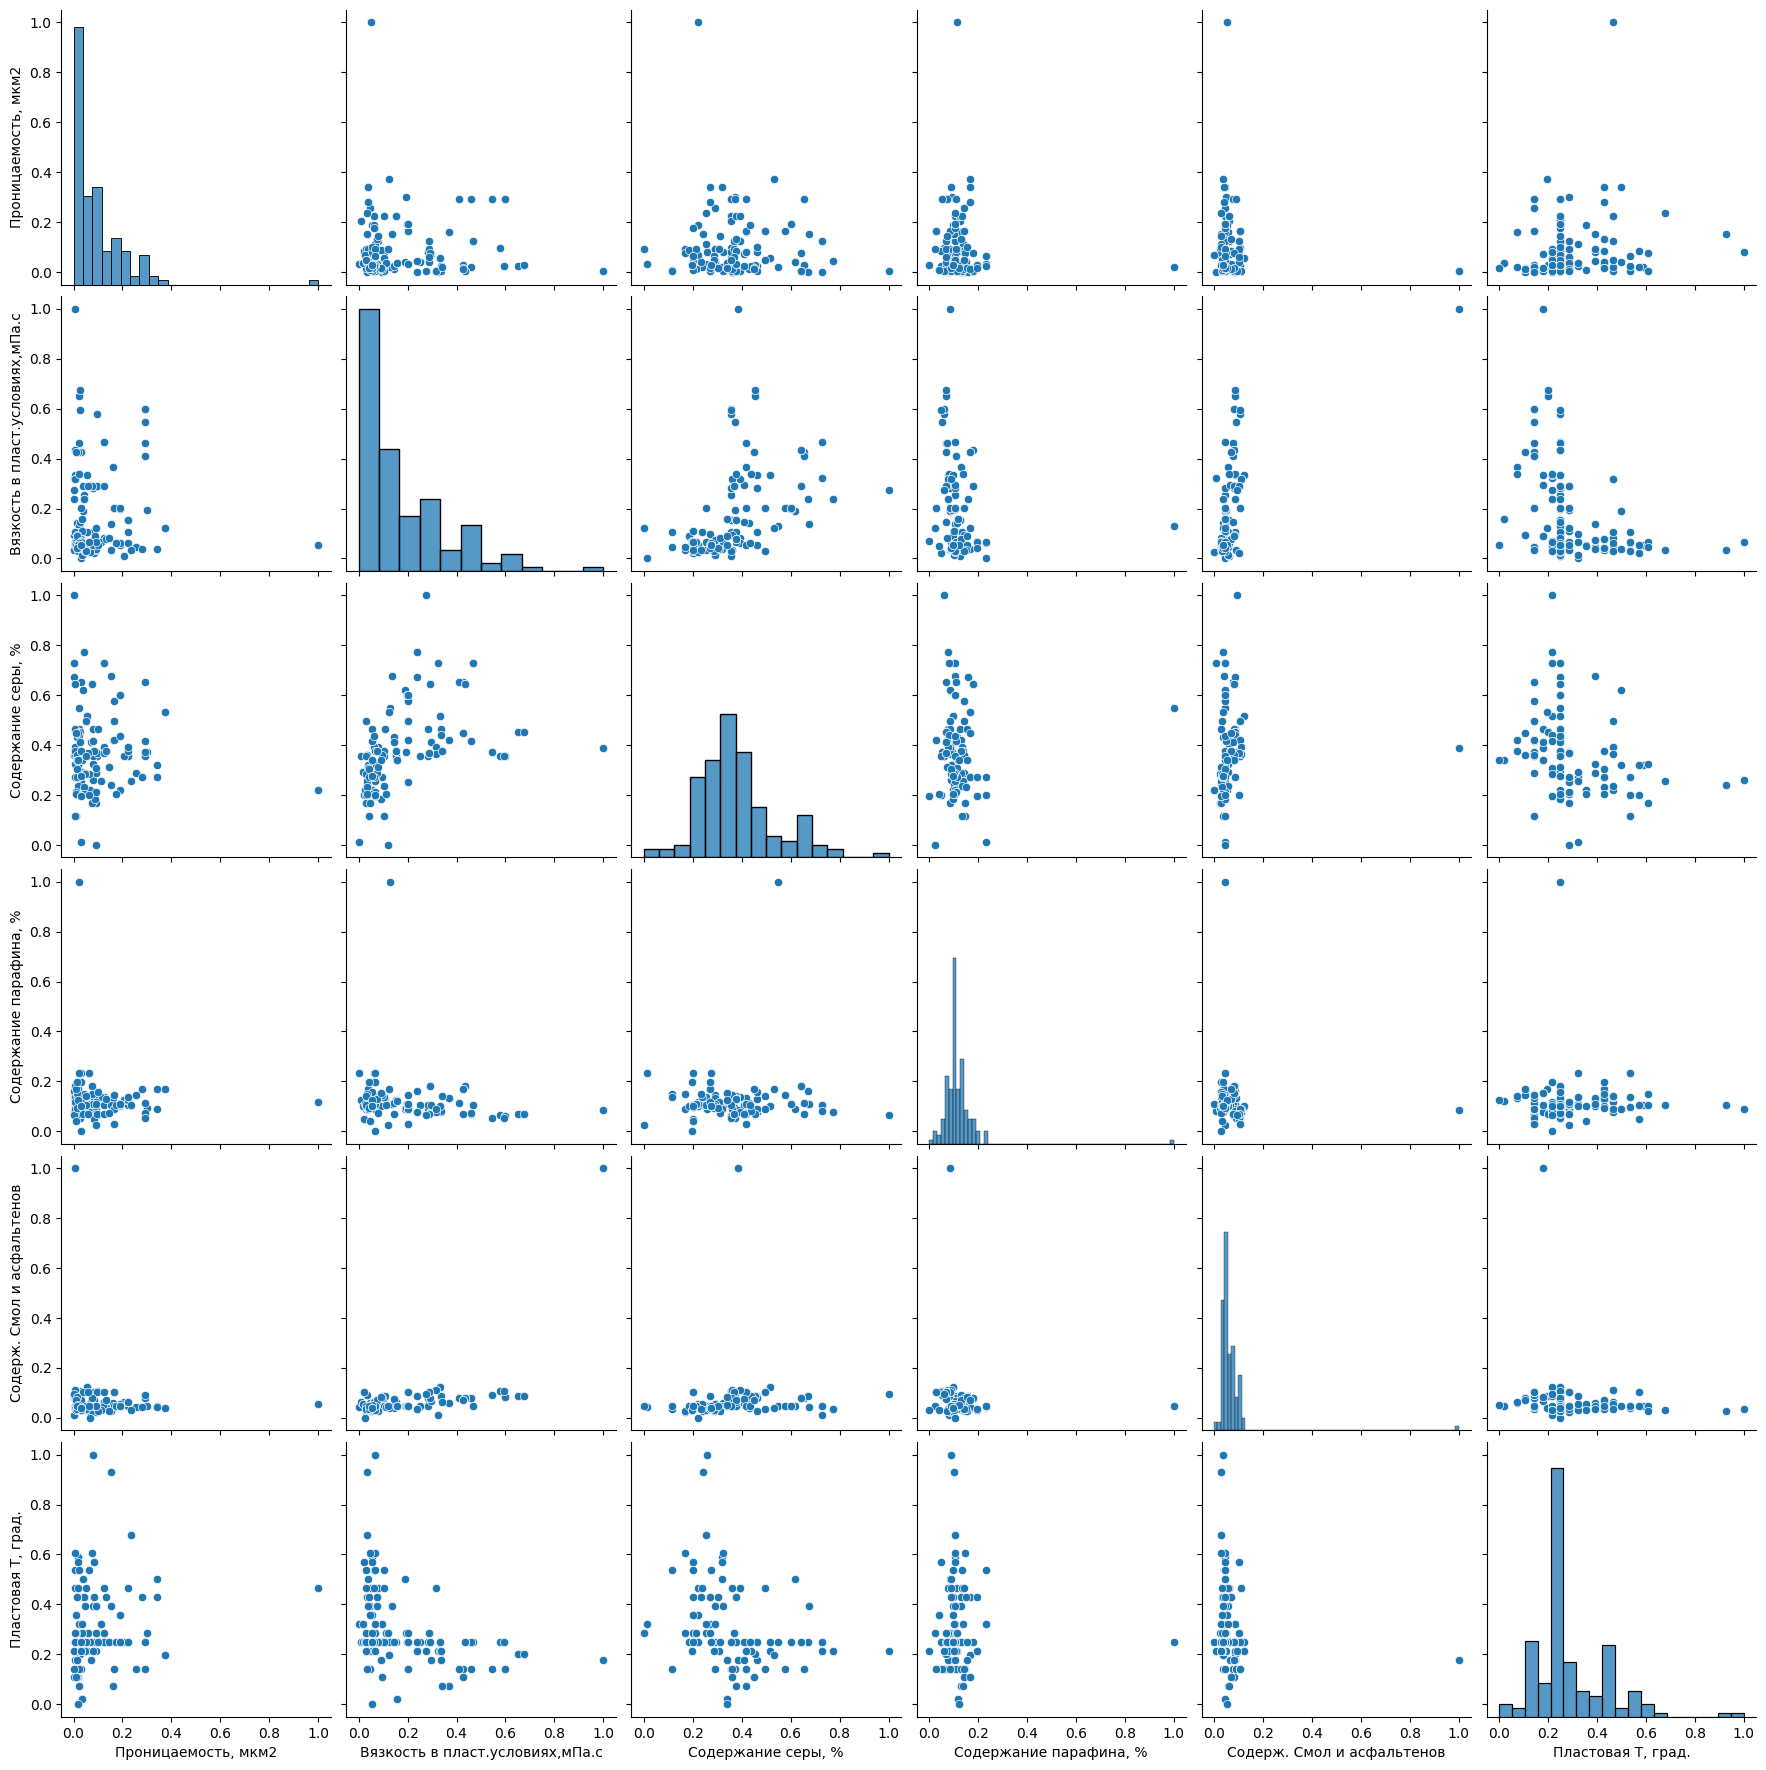

In [31]:
sns.pairplot(df_normaliz[columns_parametr[7:]], height=3)

In [32]:
e=lambda x: x<0.8 #для проницаемости, вязкости, серы, смол и асфальтенов
f=lambda x: x<0.6 #для пластовой температуры   

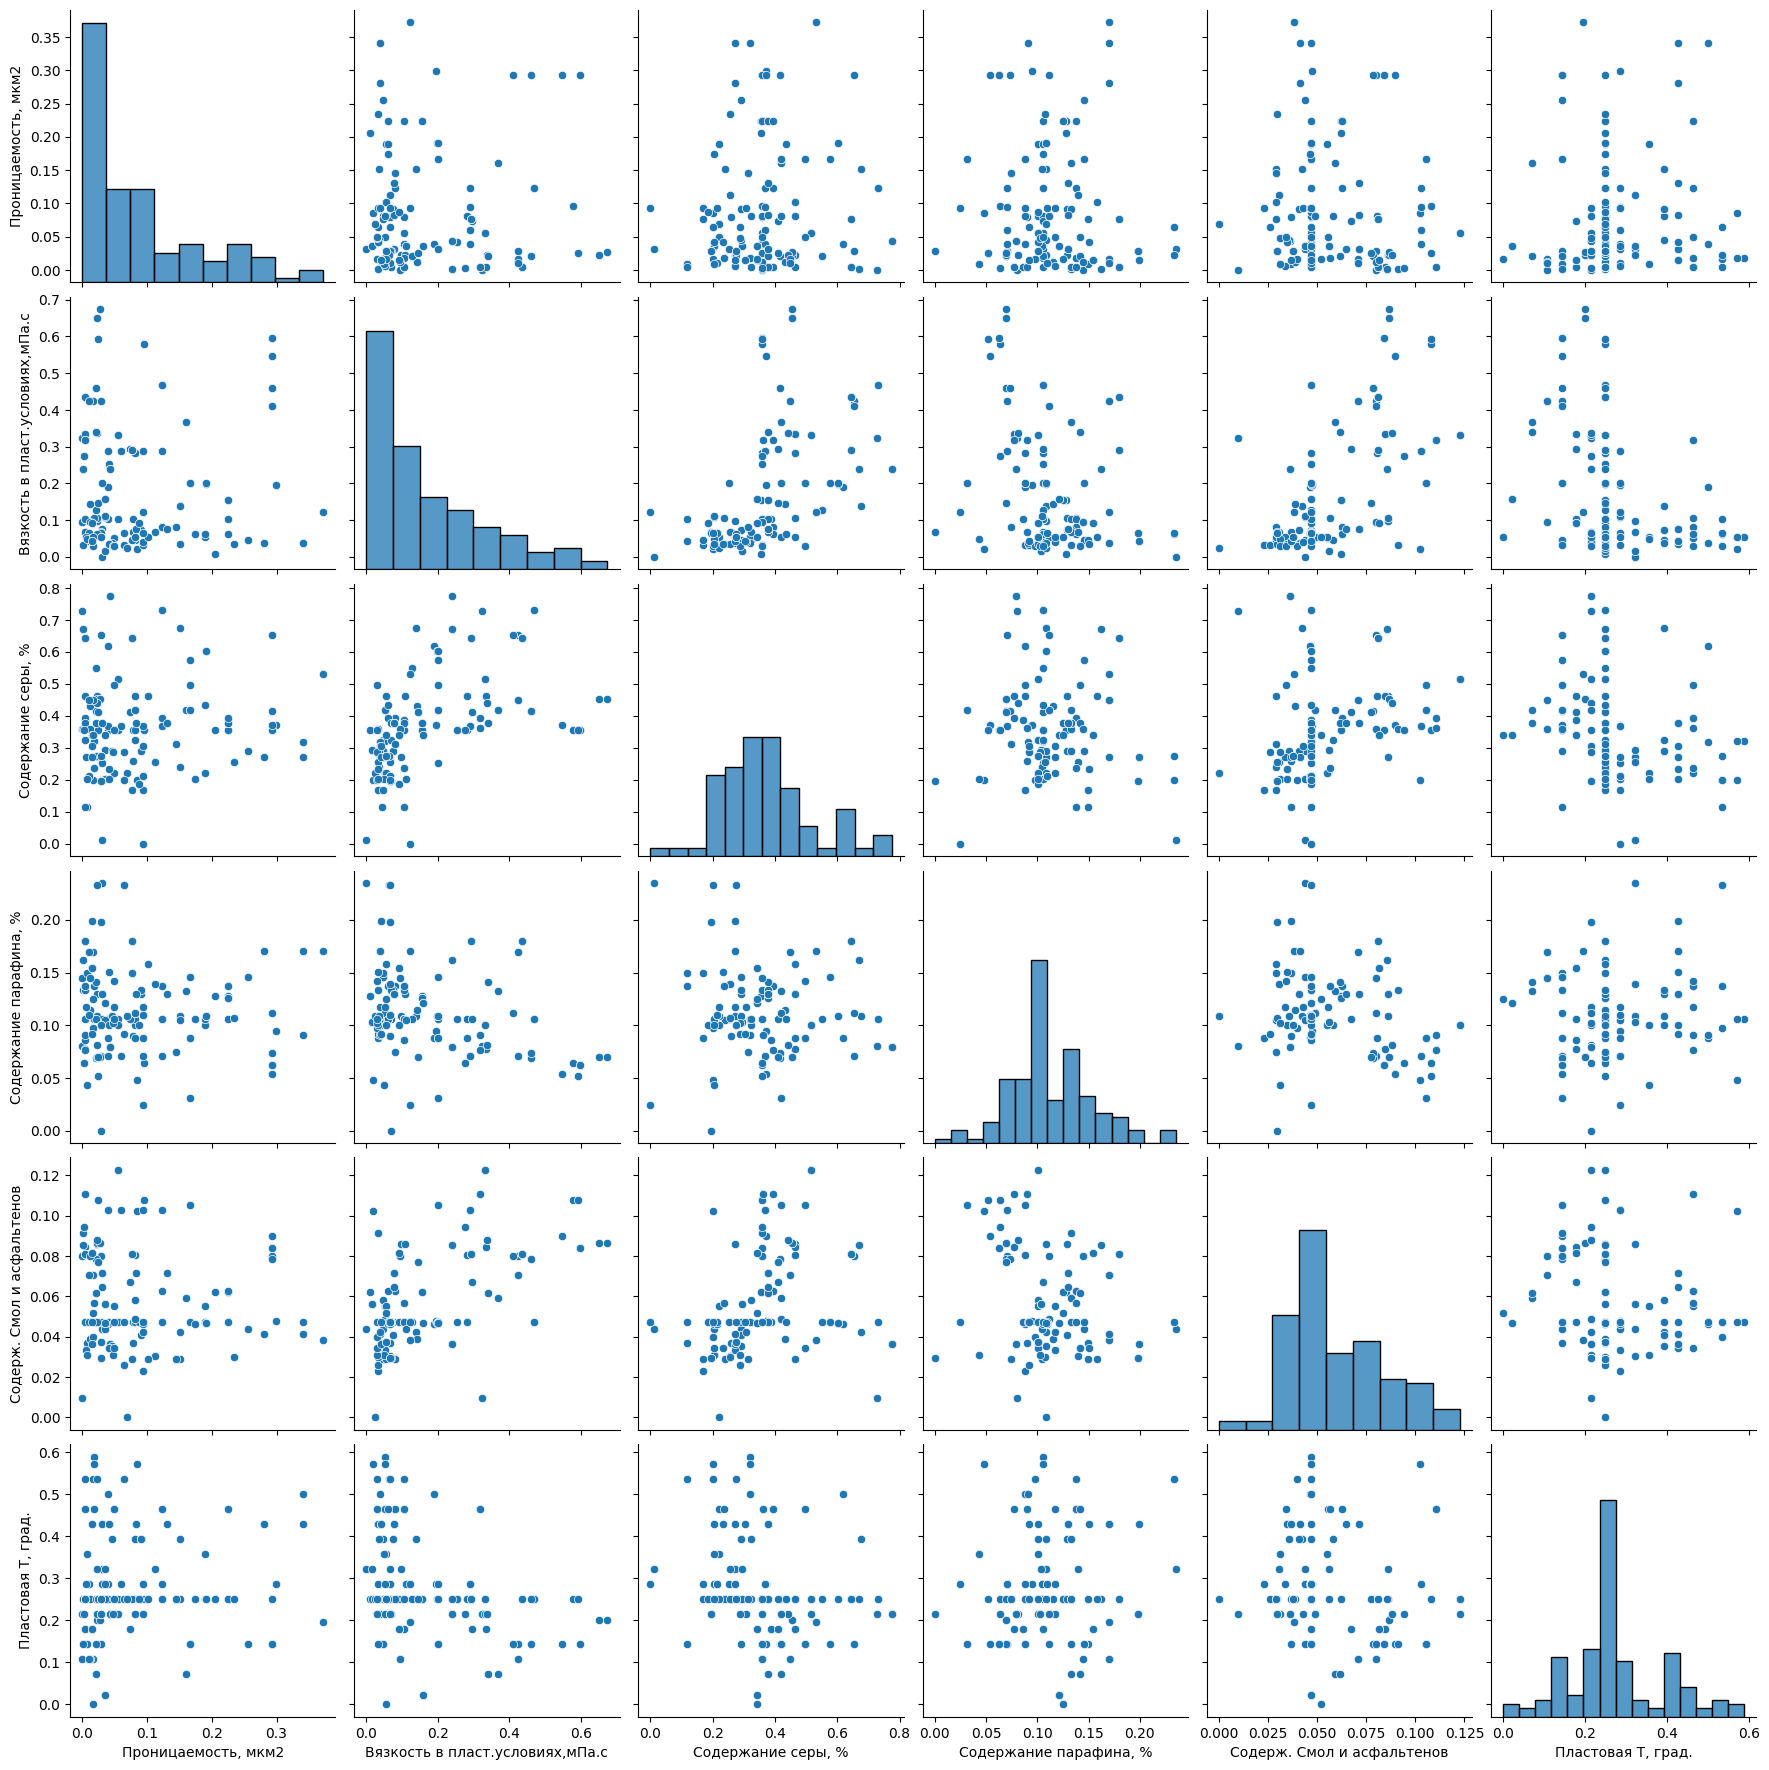

In [33]:
df_part2_clear= df_normaliz[columns_parametr[7:]].copy()
df_part2_clear['Проницаемость, мкм2']= df_normaliz['Проницаемость, мкм2'][e]
df_part2_clear['Вязкость в пласт.условиях,мПа.с']= df_normaliz['Вязкость в пласт.условиях,мПа.с'][e]
df_part2_clear['Содержание серы, %']= df_normaliz['Содержание серы, %'][e]
df_part2_clear['Содержание парафина, %']= df_normaliz['Содержание парафина, %'][e]
df_part2_clear['Содерж. Смол и асфальтенов']= df_normaliz['Содерж. Смол и асфальтенов'][e]
df_part2_clear['Пластовая Т, град.']= df_normaliz['Пластовая Т, град.'][f]

for i in df_without_0[columns_parametr[7:]]:
    median=np.median(df_normaliz[i].values)
    df_part2_clear[i]=df_part2_clear[i].fillna(median)

sns.pairplot(df_part2_clear, height=3)

<AxesSubplot:>

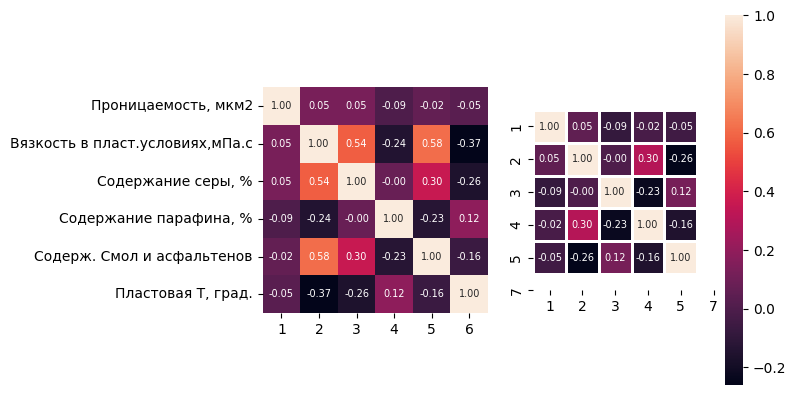

In [34]:
pylab.subplot (1, 2, 1)
sns.heatmap(df_part2_clear.corr(),cbar=False , annot=True , annot_kws={ 'size': 7},fmt='.2f', square=True, xticklabels=[1,2,3,4,5,6] )

df_part2_without_coef=df_part2_clear.copy()
df_part2_without_coef.pop('Вязкость в пласт.условиях,мПа.с')

pylab.subplot (1, 2, 2)
sns.heatmap(df_part2_without_coef.corr(),cbar=True , annot=True , annot_kws={ 'size': 7},fmt='.2f',square=True,xticklabels=[1,2,3,4,5,7], yticklabels=[1,2,3,4,5,7],linewidths=2)

In [35]:
line_reg_res_2=[]
for i in df_part2_clear[columns_parametr[7:]]:
    x=np.array(df_part2_clear[i].values).reshape((-1, 1))
    for k in df_part2_clear[columns_parametr[8:-1]]:
        y=np.array(df_part2_clear[k].values)
        t=line_reg(x,y)
        if t[0]==1:
            continue
        line_reg_res_2+=[i+' | '+ k + ': ' + str(round(t[0],4))]
line_reg_res_2

['Проницаемость, мкм2 | Вязкость в пласт.условиях,мПа.с: 0.0027',
 'Проницаемость, мкм2 | Содержание серы, %: 0.0025',
 'Проницаемость, мкм2 | Содержание парафина, %: 0.0074',
 'Проницаемость, мкм2 | Содерж. Смол и асфальтенов: 0.0004',
 'Вязкость в пласт.условиях,мПа.с | Содержание серы, %: 0.2913',
 'Вязкость в пласт.условиях,мПа.с | Содержание парафина, %: 0.0585',
 'Вязкость в пласт.условиях,мПа.с | Содерж. Смол и асфальтенов: 0.3343',
 'Содержание серы, % | Вязкость в пласт.условиях,мПа.с: 0.2913',
 'Содержание серы, % | Содержание парафина, %: 0.0',
 'Содержание серы, % | Содерж. Смол и асфальтенов: 0.0919',
 'Содержание парафина, % | Вязкость в пласт.условиях,мПа.с: 0.0585',
 'Содержание парафина, % | Содержание серы, %: 0.0',
 'Содержание парафина, % | Содерж. Смол и асфальтенов: 0.0519',
 'Содерж. Смол и асфальтенов | Вязкость в пласт.условиях,мПа.с: 0.3343',
 'Содерж. Смол и асфальтенов | Содержание серы, %: 0.0919',
 'Содерж. Смол и асфальтенов | Содержание парафина, %: 0.05

$R^2$ больше всего между параметрами Содержание серы, % - Вязкость в пласт.условиях,мПа.с и Вязкость в пласт.условиях,мПа.с - Содерж. Смол и асфальтенов

In [36]:
poly_reg_res_2=[]
for i in df_part2_clear[columns_parametr[7:]]:
    x=np.array(df_part2_clear[i].values).reshape((-1, 1))
    for k in df_part2_clear[columns_parametr[8:-1]]:
        y=np.array(df_part2_clear[k].values)
        pak=[]
        for n in range(2,6):
            poly_reg = PolynomialFeatures(degree=n)
            X_poly = poly_reg.fit_transform(x)
            t=line_reg(X_poly,y)
            if t[0]==1:
                continue
            pak+=[round(t[0],4)]
        if len(pak)!=0:
            poly_reg_res_2+=[i+' | '+ k + ': ' + str(pak)]
poly_reg_res_2

['Проницаемость, мкм2 | Вязкость в пласт.условиях,мПа.с: [0.0183, 0.0333, 0.0429, 0.0748]',
 'Проницаемость, мкм2 | Содержание серы, %: [0.0028, 0.008, 0.042, 0.0451]',
 'Проницаемость, мкм2 | Содержание парафина, %: [0.0315, 0.0315, 0.0423, 0.0509]',
 'Проницаемость, мкм2 | Содерж. Смол и асфальтенов: [0.0008, 0.0192, 0.0193, 0.0318]',
 'Вязкость в пласт.условиях,мПа.с | Содержание серы, %: [0.4323, 0.4327, 0.434, 0.4376]',
 'Вязкость в пласт.условиях,мПа.с | Содержание парафина, %: [0.0593, 0.0949, 0.0978, 0.1417]',
 'Вязкость в пласт.условиях,мПа.с | Содерж. Смол и асфальтенов: [0.3691, 0.37, 0.3817, 0.3881]',
 'Содержание серы, % | Вязкость в пласт.условиях,мПа.с: [0.2946, 0.3243, 0.3283, 0.3292]',
 'Содержание серы, % | Содержание парафина, %: [0.0125, 0.0173, 0.0759, 0.0856]',
 'Содержание серы, % | Содерж. Смол и асфальтенов: [0.206, 0.312, 0.3181, 0.3221]',
 'Содержание парафина, % | Вязкость в пласт.условиях,мПа.с: [0.0777, 0.083, 0.2844, 0.288]',
 'Содержание парафина, % | Со

Лучше всего результат Вязкость в пласт.условиях,мПа.с - Содержание серы, %. Попробую увеличить степень полинома.

In [37]:
x_0=df_part2_clear['Вязкость в пласт.условиях,мПа.с'].values
y_0=df_part2_clear['Содержание серы, %'].values

x=np.array(x_0).reshape((-1, 1))
y=np.array(y_0)

In [38]:
poly_reg = PolynomialFeatures(degree=8)
X_poly = poly_reg.fit_transform(x)

t=line_reg(X_poly,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],t[2]))

coefficient of determination(R^2):0.5028550884158988
intercept(b_0):0.10567538472412036
slope(b_1):[ 0.00000000e+00  1.23997354e+01 -3.07165302e+02  3.56567846e+03
 -2.08391898e+04  6.63457816e+04 -1.16854197e+05  1.06873592e+05
 -3.95875789e+04]


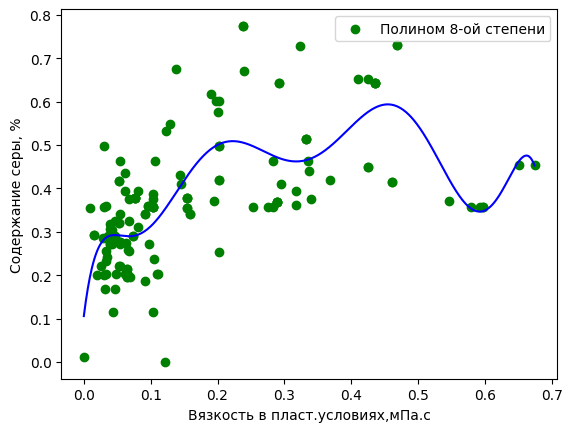

In [39]:
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y)

X_grid = np.arange(min(x),max(x),0.001)
X_grid = X_grid.reshape(len(X_grid),1) 
plt.scatter(x,y, color='green') 

plt.plot(X_grid, lin_reg2.predict(poly_reg.fit_transform(X_grid)),color='blue') 

plt.legend(['Полином 8-ой степени'])
plt.xlabel('Вязкость в пласт.условиях,мПа.с')
plt.ylabel('Содержание серы, %')
plt.show()

Теоретические данная модель имеет небольшое соответствие данным.

<div class="alert alert-block alert-info">
<b>Поиск зависимостей между парметрами подсчета запасов и дополнительными параметрами </b>
</div>

- Линейная регрессия между основными и дополнительными параметрами

In [40]:
line_reg_res_3=[]
for i in df_part1_clear[columns_parametr[:7]]:
    x=np.array(df_part1_clear[i].values).reshape((-1, 1))
    for k in df_part2_clear[columns_parametr[7:]]:
        y=np.array(df_part2_clear[k].values)
        t=line_reg(x,y)
        if t[0]==1:
            continue
        line_reg_res_3+=[i+' | '+ k + ': ' + str(round(t[0],4))]
line_reg_res_3

['Коэфф. Извлечения | Проницаемость, мкм2: 0.168',
 'Коэфф. Извлечения | Вязкость в пласт.условиях,мПа.с: 0.0007',
 'Коэфф. Извлечения | Содержание серы, %: 0.0',
 'Коэфф. Извлечения | Содержание парафина, %: 0.0026',
 'Коэфф. Извлечения | Содерж. Смол и асфальтенов: 0.0009',
 'Коэфф. Извлечения | Пластовая Т, град.: 0.0033',
 'площадь нефтеносности, тыс.м2 | Проницаемость, мкм2: 0.0024',
 'площадь нефтеносности, тыс.м2 | Вязкость в пласт.условиях,мПа.с: 0.0018',
 'площадь нефтеносности, тыс.м2 | Содержание серы, %: 0.0001',
 'площадь нефтеносности, тыс.м2 | Содержание парафина, %: 0.0115',
 'площадь нефтеносности, тыс.м2 | Содерж. Смол и асфальтенов: 0.0026',
 'площадь нефтеносности, тыс.м2 | Пластовая Т, град.: 0.0298',
 'Нефтенасыщенная толщина,эффект. м | Проницаемость, мкм2: 0.0298',
 'Нефтенасыщенная толщина,эффект. м | Вязкость в пласт.условиях,мПа.с: 0.0282',
 'Нефтенасыщенная толщина,эффект. м | Содержание серы, %: 0.0231',
 'Нефтенасыщенная толщина,эффект. м | Содержание пара

По результатам линейной моделью можно описать зависимость плотности от вязкости.

In [41]:
x_0=df_part1_clear['Плотность г/см3'].values
y_0=df_part2_clear['Вязкость в пласт.условиях,мПа.с'].values

x=np.array(x_0).reshape((-1, 1))
y=np.array(y_0)

In [42]:
def line_reg(x,y):
    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)
    b_0 = model.intercept_
    b_1 = model.coef_
    return r_sq, model.intercept_, model.coef_, model

In [43]:
t=line_reg(x,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],*t[2]))

coefficient of determination(R^2):0.6612975766056701
intercept(b_0):-0.16464537473216476
slope(b_1):0.6211302786034405


Text(0, 0.5, 'Вязкость в пласт.условиях,мПа.с')

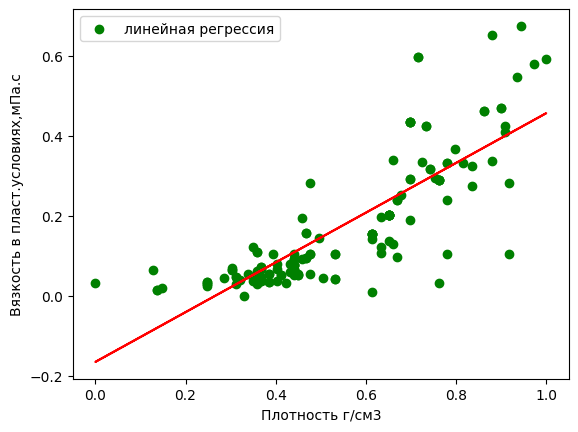

In [44]:
y_pred = t[-1].predict(x)
plt.scatter(x_0, y_0, color='green')
plt.plot( x, y_pred,'r-')
plt.legend(['линейная регрессия'])
plt.xlabel('Плотность г/см3')
plt.ylabel('Вязкость в пласт.условиях,мПа.с')

In [45]:
poly_reg_res_3=[]
for i in df_part1_clear[columns_parametr[:7]]:
    x=np.array(df_part1_clear[i].values).reshape((-1, 1))
    for k in df_part2_clear[columns_parametr[7:]]:
        y=np.array(df_part2_clear[k].values)
        pak=[]
        for n in range(2,6):
            poly_reg = PolynomialFeatures(degree=n)
            X_poly = poly_reg.fit_transform(x)
            t=line_reg(X_poly,y)
            if t[0]==1:
                continue
            pak+=[round(t[0],4)]
        if len(pak)!=0:
            poly_reg_res_3+=[i+' | '+ k + ': ' + str(pak)]
poly_reg_res_3

['Коэфф. Извлечения | Проницаемость, мкм2: [0.1772, 0.178, 0.2115, 0.2139]',
 'Коэфф. Извлечения | Вязкость в пласт.условиях,мПа.с: [0.0183, 0.0257, 0.035, 0.0409]',
 'Коэфф. Извлечения | Содержание серы, %: [0.0097, 0.0141, 0.0158, 0.016]',
 'Коэфф. Извлечения | Содержание парафина, %: [0.006, 0.0062, 0.0064, 0.0088]',
 'Коэфф. Извлечения | Содерж. Смол и асфальтенов: [0.0479, 0.0528, 0.0544, 0.0548]',
 'Коэфф. Извлечения | Пластовая Т, град.: [0.0531, 0.0835, 0.0835, 0.1018]',
 'площадь нефтеносности, тыс.м2 | Проницаемость, мкм2: [0.0203, 0.0624, 0.0687, 0.0687]',
 'площадь нефтеносности, тыс.м2 | Вязкость в пласт.условиях,мПа.с: [0.0065, 0.0169, 0.0244, 0.0389]',
 'площадь нефтеносности, тыс.м2 | Содержание серы, %: [0.0201, 0.0211, 0.0355, 0.0355]',
 'площадь нефтеносности, тыс.м2 | Содержание парафина, %: [0.0175, 0.0307, 0.0419, 0.0462]',
 'площадь нефтеносности, тыс.м2 | Содерж. Смол и асфальтенов: [0.0103, 0.0104, 0.0409, 0.0481]',
 'площадь нефтеносности, тыс.м2 | Пластовая Т

В полиномиальных моделях помимо увеличения $R^2$ плотности от вязкости, проявились зависимости плотности от содержания серы и смол с асфальтенами.

In [46]:
x_0=df_part1_clear['Плотность г/см3'].values
y_0=df_part2_clear['Вязкость в пласт.условиях,мПа.с'].values

x=np.array(x_0).reshape((-1, 1))
y=np.array(y_0)

In [47]:
poly_reg = PolynomialFeatures(degree=7)
X_poly = poly_reg.fit_transform(x)

t=line_reg(X_poly,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],t[2]))

coefficient of determination(R^2):0.7276485878490941
intercept(b_0):0.03619489850963206
slope(b_1):[ 0.00000000e+00  4.86343361e-02 -5.13543030e+00  5.01948974e+01
 -1.90071551e+02  3.47147613e+02 -3.00587335e+02  9.90261268e+01]


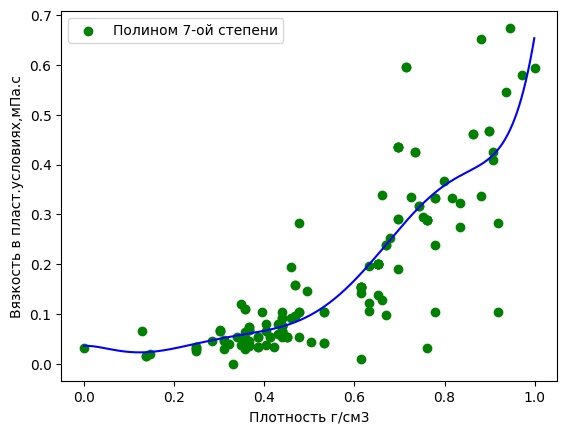

In [48]:
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y)

X_grid = np.arange(min(x),max(x),0.001)
X_grid = X_grid.reshape(len(X_grid),1) 
plt.scatter(x,y, color='green') 

plt.plot(X_grid, lin_reg2.predict(poly_reg.fit_transform(X_grid)),color='blue') 

plt.legend(['Полином 7-ой степени'])
plt.xlabel('Плотность г/см3')
plt.ylabel('Вязкость в пласт.условиях,мПа.с')
plt.show()

In [49]:
y_0=df_part2_clear['Содержание серы, %'].values
y=np.array(y_0)
poly_reg = PolynomialFeatures(degree=7)
X_poly = poly_reg.fit_transform(x)

t=line_reg(X_poly,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],t[2]))

coefficient of determination(R^2):0.4622191336476599
intercept(b_0):0.1701512278271174
slope(b_1):[    0.            -1.2951082     34.84625689  -235.93979104
   719.52319997 -1097.63424637   820.89069339  -240.24771813]


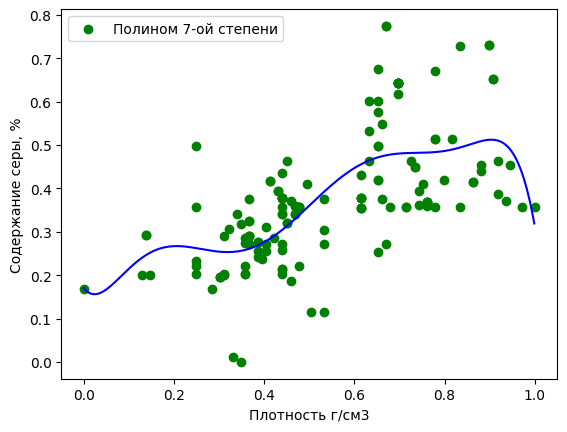

In [50]:
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y)

X_grid = np.arange(min(x),max(x),0.001)
X_grid = X_grid.reshape(len(X_grid),1) 
plt.scatter(x,y, color='green') 

plt.plot(X_grid, lin_reg2.predict(poly_reg.fit_transform(X_grid)),color='blue') 

plt.legend(['Полином 7-ой степени'])
plt.xlabel('Плотность г/см3')
plt.ylabel('Содержание серы, %')
plt.show()

In [51]:
y_0=df_part2_clear['Содерж. Смол и асфальтенов'].values
y=np.array(y_0)
poly_reg = PolynomialFeatures(degree=6)
X_poly = poly_reg.fit_transform(x)

t=line_reg(X_poly,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],t[2]))

coefficient of determination(R^2):0.40725093773584675
intercept(b_0):0.030650144671769644
slope(b_1):[ 0.          0.38205457 -2.30605946  4.59817338 -1.57342384 -3.3639485
  2.3325244 ]


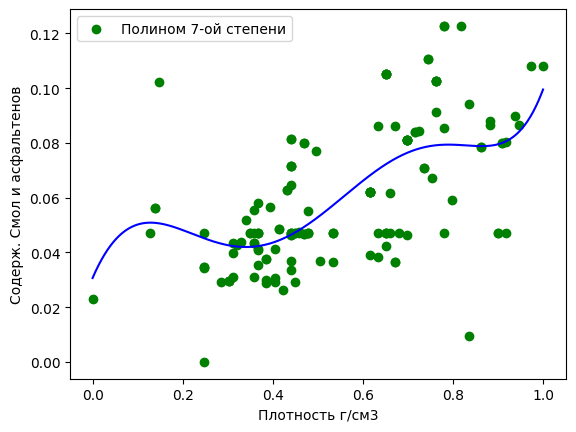

In [52]:
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y)

X_grid = np.arange(min(x),max(x),0.001)
X_grid = X_grid.reshape(len(X_grid),1) 
plt.scatter(x,y, color='green') 

plt.plot(X_grid, lin_reg2.predict(poly_reg.fit_transform(X_grid)),color='blue') 

plt.legend(['Полином 7-ой степени'])
plt.xlabel('Плотность г/см3')
plt.ylabel('Содерж. Смол и асфальтенов')
plt.show()

<strong>Вывод</strong>: местами мной были получены интуитиво понятные зависимости. Для некоторых их них вероятно требуется провести моделирование нелинейных связей с экспоненциальным, логарифмическим и другими преобразованиями.

backup

In [53]:
e=lambda x: x<80 #для проницаемости, вязкости, серы, смол и асфальтенов
df_part3_clear= df_without_0[columns_parametr[7:]].copy()
df_part3_clear['Вязкость в пласт.условиях,мПа.с']= df_without_0['Вязкость в пласт.условиях,мПа.с'][e]

median=np.median(df_without_0['Плотность г/см3'].values)
df_part3_clear['Вязкость в пласт.условиях,мПа.с']=df_part3_clear['Вязкость в пласт.условиях,мПа.с'].fillna(median)

In [54]:
x_0=df_without_0['Плотность г/см3'].values
y_0=df_part3_clear['Вязкость в пласт.условиях,мПа.с'].values

x=np.array(x_0).reshape((-1, 1))
y=np.array(y_0)

In [55]:
poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(x)

t=line_reg(X_poly,y)
print('coefficient of determination(R^2):{0}\nintercept(b_0):{1}\nslope(b_1):{2}'.format(t[0],t[1],t[2]))

coefficient of determination(R^2):0.6963878568162865
intercept(b_0):-503533.0439945151
slope(b_1):[       0.          2293429.23553927 -3909588.60475909  2955912.25953662
  -836195.96386338]


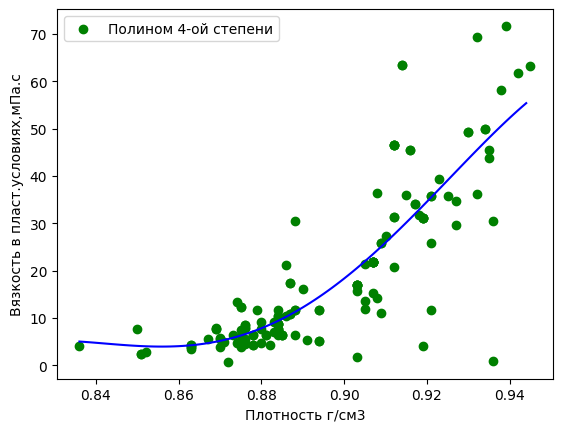

In [56]:
lin_reg2 = LinearRegression()
lin_reg2.fit(X_poly,y)

X_grid = np.arange(min(x),max(x),0.001)
X_grid = X_grid.reshape(len(X_grid),1) 
plt.scatter(x,y, color='green') 

plt.plot(X_grid, lin_reg2.predict(poly_reg.fit_transform(X_grid)),color='blue') 

plt.legend(['Полином 4-ой степени'])
plt.xlabel('Плотность г/см3')
plt.ylabel('Вязкость в пласт.условиях,мПа.с')
plt.show()

<AxesSubplot:>

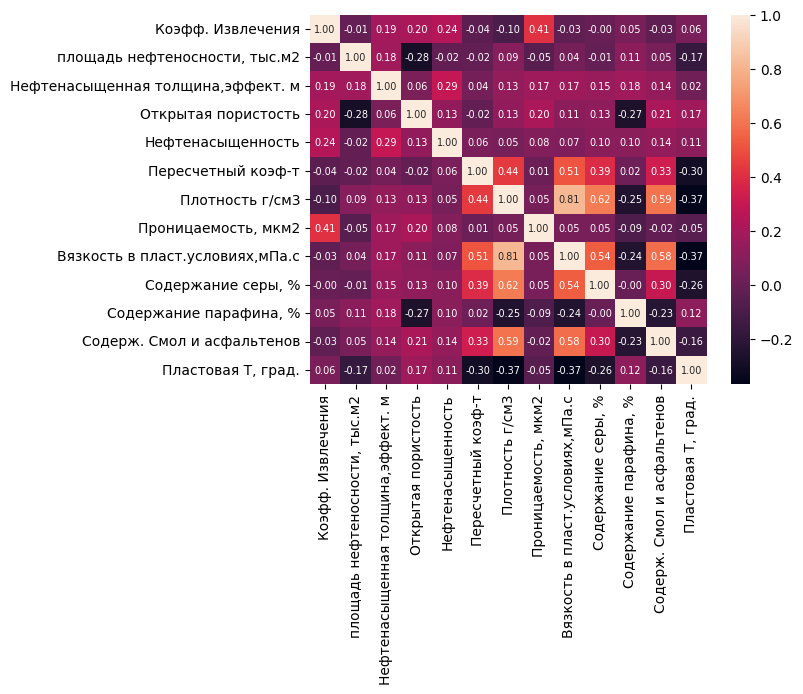

In [57]:
df_all_clear=pd.concat([df_part1_clear,df_part2_clear],axis=1)
sns.heatmap(df_all_clear.corr(), annot=True , annot_kws={ 'size': 7},fmt='.2f')